In [1]:
import json
import os
import random
import re
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import stanza
import stopwordsiso as stopwords
import torch
import wandb
from datasets import Dataset
from dotenv import load_dotenv
from IPython.display import Image, display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             precision_recall_fscore_support)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.nn.functional import softmax
from tqdm import tqdm
from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          Trainer, TrainingArguments)


/opt/homebrew/Caskroom/miniconda/base/envs/seznam/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
load_dotenv()
wandb_key = os.getenv("WANDB_KEY")

wandb.login(key=wandb_key)


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/artemsorokin/.netrc


True

In [13]:
df = pd.read_csv("data/sportoclanky.csv")


In [14]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111218 entries, 0 to 111217
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   category   111218 non-null  object
 1   rss_title  111218 non-null  object
 2   rss_perex  111218 non-null  object
dtypes: object(3)
memory usage: 2.5+ MB


In [15]:
df.isna().sum()


category     0
rss_title    0
rss_perex    0
dtype: int64

In [16]:
# checking for empty rows
df[df.eq("").any(axis=1)]


,category,rss_title,rss_perex


In [ ]:
# duplicate check. I have set the keep=False attribute to make sure of this.
df[df.duplicated(keep=False)].sort_values(by="rss_title")


,category,rss_title,rss_perex
1231,fotbal,"""Boží ruka"" i zářez Chelsea či Irů. Kdy by vid...",Po úterním přátelském utkání Francie se Španěl...
37888,fotbal,"""Boží ruka"" i zářez Chelsea či Irů. Kdy by vid...",Po úterním přátelském utkání Francie se Španěl...
49017,fotbal,"""Kolotočář"" Messi? Superhvězda si v Číně otevř...",Argentinská fotbalová hvězda Lionel Messi bude...
52322,fotbal,"""Kolotočář"" Messi? Superhvězda si v Číně otevř...",Argentinská fotbalová hvězda Lionel Messi bude...
94592,fotbal,"""Nový Neymar"" do Realu? Talent hrál jednou za ...","V červenci oslaví sladkých sedmnáct, za A tým ..."
...,...,...,...
91239,fotbal,Žádné rošády. Bohumil Páník i v příští sezoně ...,"Trenér Bohumil Páník, který s fotbalisty Fasta..."
110730,hokej,Žádný průšvih ani šampaňské. Chceme se odrazit...,Vítkovice prožily zvláštní sezonu. V létě se n...
66213,hokej,Žádný průšvih ani šampaňské. Chceme se odrazit...,Vítkovice prožily zvláštní sezonu. V létě se n...
67910,hokej,„Fin“ Hrachovina hraje o titul: Byl bych parch...,Stále zůstává trochu ukrytý před zraky českých...


In [18]:
print(f"shape before drop_duplicates: {df.shape}")
df.drop_duplicates(inplace=True)
print(f"shape after drop_duplicates: {df.shape}")


shape before drop_duplicates: (111218, 3)
shape after drop_duplicates: (104033, 3)


In [ ]:
# combining text fields. We will only need one text field for model finetuning.
df["text"] = df["rss_title"] + "; " + df["rss_perex"]
df.drop(columns=["rss_title", "rss_perex"], inplace=True)


In [ ]:
# stanza initialization for Czech language
nlp = stanza.Pipeline(
    lang="cs", processors="tokenize,lemma", use_gpu=False
)


2025-03-30 19:48:05 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-03-30 19:48:05 INFO: Downloaded file to /Users/artemsorokin/stanza_resources/resources.json
2025-03-30 19:48:05 WARNING: Language cs package default expects mwt, which has been added
2025-03-30 19:48:05 INFO: Loading these models for language: cs (Czech):
| Processor | Package      |
----------------------------
| tokenize  | pdt          |
| mwt       | pdt          |
| lemma     | pdt_nocharlm |

2025-03-30 19:48:05 INFO: Using device: cpu
2025-03-30 19:48:05 INFO: Loading: tokenize
2025-03-30 19:48:05 INFO: Loading: mwt
2025-03-30 19:48:05 INFO: Loading: lemma
2025-03-30 19:48:06 INFO: Done loading processors!


In [21]:
def clean_text_spacy(text):
    text = re.sub(r"<[^>]+>", "", text)  # remove html
    text = re.sub(r"[^\w\s]", "", text)  # removing punctuation and special characters
    text = " ".join(text.lower().split())  # lower case and remove extra spaces
    doc = nlp(text)

    # Фильтрация токенов: убираем стоп-слова и оставляем леммы
    cleaned_tokens = [
        word.lemma
        for sent in doc.sentences
        for word in sent.words
        if word.text.lower() not in czech_stopwords and word.lemma
    ]

    # Соединение токенов обратно в строку
    cleaned_text = " ".join(cleaned_tokens)
    return cleaned_text.strip()


czech_stopwords = stopwords.stopwords("cs")
tqdm.pandas()
df["text"] = df["text"].progress_apply(clean_text_spacy)


100%|██████████| 104033/104033 [1:06:55<00:00, 25.91it/s]


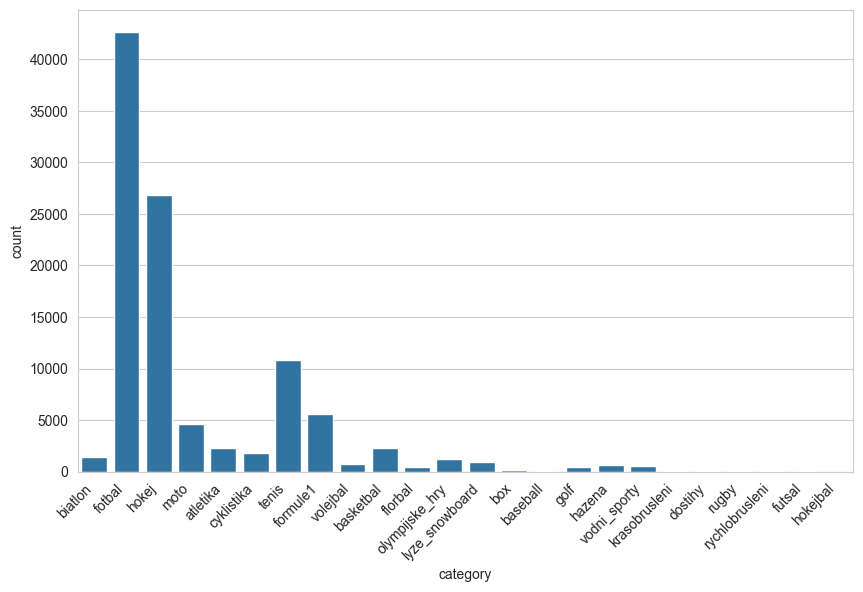

In [22]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="category")
plt.xticks(rotation=45, ha="right")
plt.show()


In [23]:
# Make a numeric representation of the categories
encoder = LabelEncoder()
df["label"] = encoder.fit_transform(df["category"])


In [ ]:
df.to_csv("data/sportoclanky_cleaned_stanza.csv", index=False)


In [25]:
# get weights so that the model pays more attention to classes that are poorly represented
# reindex is used to create a sequence of weights that corresponds to their indexes
class_counts = df["category"].value_counts().reindex(encoder.classes_).values
weights = 1 / class_counts
norm_weights = weights / weights.min()


In [26]:
tokenizer = AutoTokenizer.from_pretrained("ufal/robeczech-base")
print(f"max_length = {tokenizer.model_max_length}")


max_length = 512


In [27]:
def get_token_length(text):
    tokens = tokenizer.encode(text, add_special_tokens=True)  # acitvate [CLS] and [SEP]
    return len(tokens)

df["token_length"] = df["text"].apply(get_token_length)


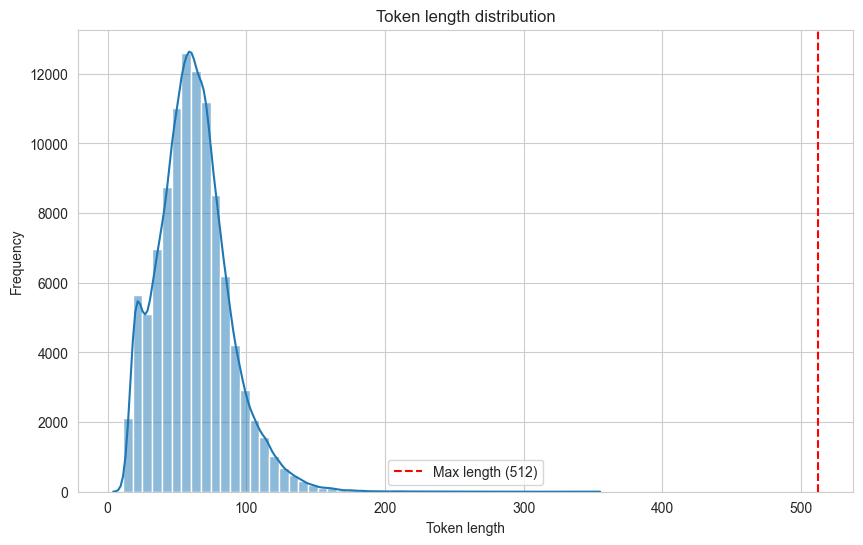

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(df["token_length"], bins=50, kde=True)
plt.axvline(512, color="red", linestyle="--", label="Max length (512)")
plt.title("Token length distribution")
plt.xlabel("Token length")
plt.ylabel("Frequency")
plt.legend()
plt.show()


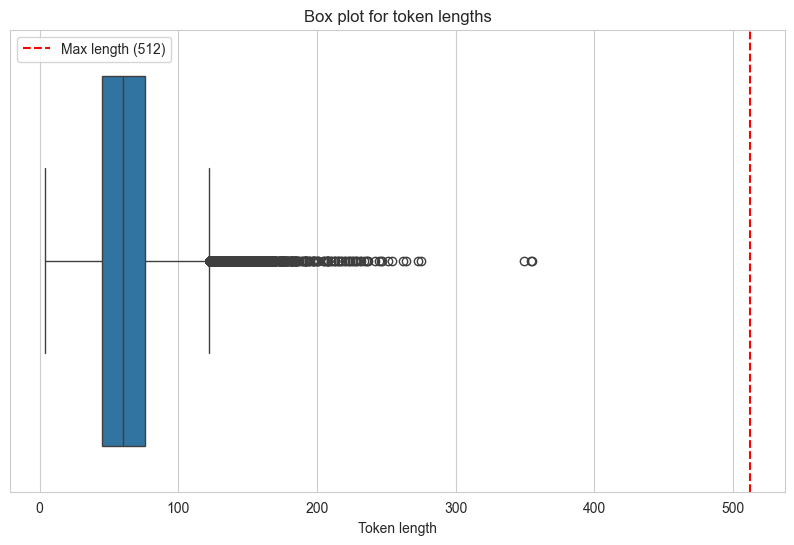

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["token_length"])
plt.axvline(512, color="red", linestyle="--", label="Max length (512)")
plt.title("Box plot for token lengths")
plt.xlabel("Token length")
plt.legend()
plt.show()


Based on these graphs, we can almost all objects have less than 256 tokens. We will use this number for the next tokenization.

In [30]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(42)


In [ ]:
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"])

train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df["label"])

print(
    f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}"
)


Train size: 66580, Validation size: 16646, Test size: 20807


#### Fine-Tuning `ufal/robeczech-base` for Classification

This section fine-tunes the `ufal/robeczech-base` model, a Czech BERT model by ÚFAL, for classifying sports articles from `sportoclanky.csv`. After splitting the data into train, validation, and test sets, we preprocess the text, tokenize it with `AutoTokenizer`, train the model using `Trainer`, and evaluate performance with accuracy, precision, recall, and F1-score.

In [19]:
train_ds = Dataset.from_pandas(train_df, split="train")
val_ds = Dataset.from_pandas(val_df, split="validation")
test_ds = Dataset.from_pandas(test_df, split="test")


In [ ]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"], truncation=True, padding="max_length", max_length=256
    )

tokenized_train_ds = train_ds.map(tokenize_function, batched=True)
tokenized_val_ds = val_ds.map(tokenize_function, batched=True)
tokenized_test_ds = test_ds.map(tokenize_function, batched=True)


Map: 100%|██████████| 20807/20807 [00:02<00:00, 8199.88 examples/s]


In [ ]:
# prepare model for classification - here I add a “head” for classification on top of the existing model
num_labels = len(set(df["label"]))  # number of unique categories
model = AutoModelForSequenceClassification.from_pretrained(
    "ufal/robeczech-base", num_labels=num_labels
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ufal/robeczech-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(pred):
    # using 'weighted' average to account for class imbalance in the dataset
    labels = pred.label_ids # true labels from the dataset
    preds = pred.predictions.argmax(-1) # predicted labels (highest probability)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted"
    )
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


In [ ]:
training_args = TrainingArguments(
    output_dir="/work/results",  # folder to save the results
    evaluation_strategy="epoch",  # evaluate the model after each epoch
    save_strategy="epoch",  # save the model after each epoch
    learning_rate=2e-5,  # training speed
    per_device_train_batch_size=16,  # training patch size
    per_device_eval_batch_size=16,  # evaluation patch size
    num_train_epochs=3,  # number of epochs
    weight_decay=0.01,  # regularization
    load_best_model_at_end=True,  # load the best model by metric
    metric_for_best_model="f1",  # use F1 to select the best model
    report_to="wandb",
    run_name="experiment-1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_val_ds,
    compute_metrics=compute_metrics,
)


/opt/homebrew/Caskroom/miniconda/base/envs/seznam/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()


In [ ]:
metrics = trainer.evaluate()

with open("/work/metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

model.save_pretrained("/work/my_finetuned_model")
tokenizer.save_pretrained("/work/my_finetuned_model")


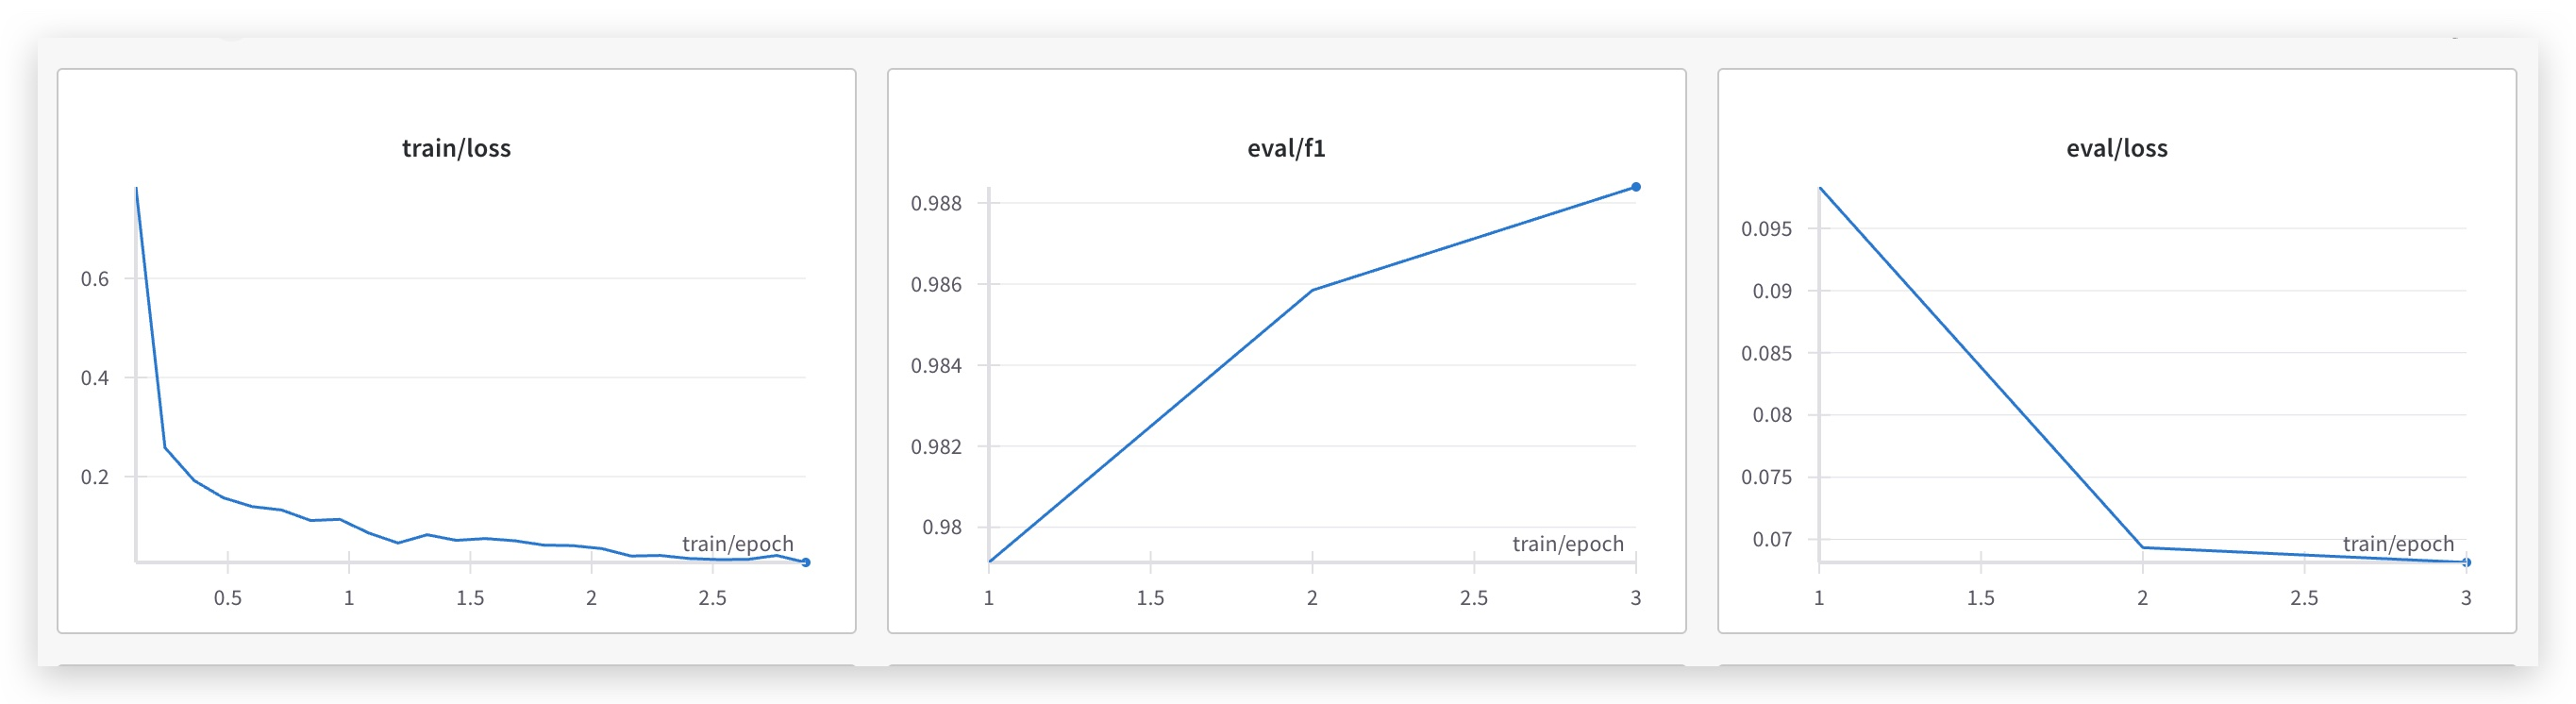

In [ ]:
# metrics obtained through wandb
display(Image(filename="metrics.jpg"))


In [ ]:
# move metrics to the model folder before archiving
shutil.move(
    "/kaggle/working/metrics.json", "/kaggle/working/my_finetuned_model/metrics.json"
)
# create an archive with the model and metrics
shutil.make_archive("my_finetuned_model", "zip", "/kaggle/working/my_finetuned_model")


### Model Evaluation Metrics

Below are the evaluation results after fine-tuning a model using Hugging Face Transformers. These metrics are computed on the validation dataset (`tokenized_val_ds`) after the 3rd epoch of training.

- **`eval_loss`: 0.06814562529325485**  
  *The average loss on the validation set. A lower value indicates better model performance in terms of the loss function.*

- **`eval_accuracy`: 0.9884656974648565**  
  *The accuracy of the model on the validation set, representing the proportion of correctly predicted samples. Here, ~98.85% of predictions were correct.*

- **`eval_f1`: 0.9883964720169838**  
  *The F1 score, a harmonic mean of precision and recall. This is the metric used to select the best model (`metric_for_best_model="f1"`). A value of ~98.84% indicates strong performance.*

- **`eval_runtime`: 464.2244**  
  *The total time (in seconds) taken to evaluate the model on the validation set. This is roughly 7 minutes and 44 seconds.*


##### Summary
These metrics suggest that the fine-tuned model performs exceptionally well on the validation set, with high accuracy, precision, recall, and F1 scores (all around 98.8%). The low evaluation loss further confirms the model's strong generalization ability after 3 epochs of training.

The model was trained in the `cloud`. 

The trained model can be tried in the follow cell:

In [48]:
# the resulting model can be tried here
tokenizer = AutoTokenizer.from_pretrained("finetuned_model")
model = AutoModelForSequenceClassification.from_pretrained(
    "finetuned_model", num_labels=24
)

text = val_df["text"].loc[0]
category = val_df["category"].loc[0]
label = val_df["label"].loc[0]

inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits

# сonvert to probabilities
probabilities = softmax(logits, dim=-1)

# predicted class
predicted_class = torch.argmax(logits, dim=-1).item()
print(f"Predicted class index: {predicted_class}")
print(f"Probability of the predicted class: {probabilities[0][predicted_class]:.4f}")
print(f"True class - {category}. True index {label}")


Predicted class index: 3
Probability of the predicted class: 0.9972
True class - biatlon. True index 3


----
##### Text Classification with TF-IDF and Logistic Regression

This section implements a text classification pipeline using TF-IDF vectorization and logistic regression on the `sportoclanky.csv` dataset. After splitting the data into train, validation, and test sets, we vectorize the text with `TfidfVectorizer` (limited to 5000 features), train a `LogisticRegression` model, and evaluate its performance on the validation set using accuracy, precision, recall, and F1-score.

In [49]:
X_train = train_df["text"]
y_train = train_df["label"]
X_val = val_df["text"]
y_val = val_df["label"]


In [50]:
# text vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # limit to 5000 most frequent words
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# training the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# prediction on the validation set
y_pred = model.predict(X_val_tfidf)

# evaluation of results
accuracy = accuracy_score(y_val, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_val, y_pred, average="weighted"
)


/opt/homebrew/Caskroom/miniconda/base/envs/seznam/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


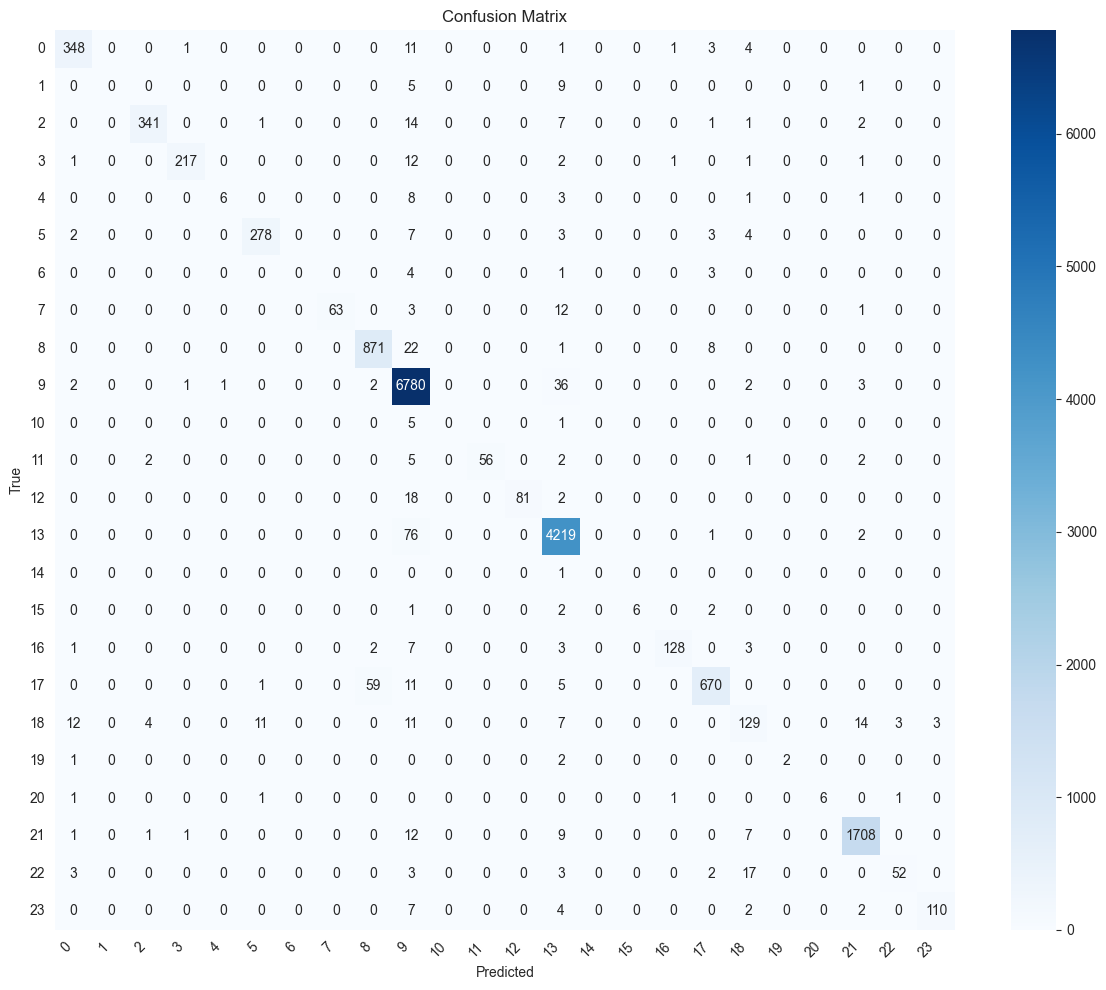

In [51]:
# confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()


### Model Evaluation Metrics

Below are the evaluation results for a Logistic Regression model trained on TF-IDF vectorized text data. The metrics are computed on the validation set (`X_val_tfidf`, `y_val`) after training.

- **`accuracy`: 0.9654571668869398**  
  *The accuracy of the model on the validation set, representing the proportion of correctly predicted samples. Approximately 96.55% of predictions were correct.*

- **`f1`: 0.9637111316643572**  
  *The weighted F1 score, a harmonic mean of precision and recall. A value of ~96.37% reflects a balanced trade-off between precision and recall.*

##### Summary
The Logistic Regression model, trained on TF-IDF features, achieves strong performance on the validation set, with an accuracy of 96.55% and similarly high precision, recall, and F1 scores (all around 96.3–96.5%). These results indicate that the model generalizes well to the validation data, with a slight variation between precision and recall suggesting minor differences in class-specific performance.

-----
### Conclusion
`TfidfVectorizer` and `LogisticRegression` are much lighter in terms of implementation and computational power.
The pre-trained `ufal/robeczech-base` model for classification is more accurate, but computationally more difficult to implement.

After selecting a model for production, it will be necessary to test it on a `training` and `validation` sample after obtaining metrics on a `test` sample.

After the final metrics are obtained, it is possible to perform additional training on **`all data`**.
